In [1]:
# Import könyvtárak
import os
import json
import re
import unicodedata
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Konfigurációs változók
STEP_PREFIX = '02-preparation'

In [3]:
def clean_text(text):
    """Clean and preprocess text data for Hungarian legal texts (lowercase, normalize, strip)."""
    if pd.isna(text) or text == "":
        return ""
    text = str(text)
    text = text.lower()
    text = unicodedata.normalize('NFC', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\.,!\?;:\-–—\(\)"\'„"%/€$…]', '', text)
    return text.strip()

In [4]:
def stratified_split(df, target_column, test_size=0.2, val_size=0.2, random_state=42):
    """Split data into train/validation/test sets with stratification."""
    train_val, test = train_test_split(
        df, test_size=test_size, stratify=df[target_column], random_state=random_state
    )
    val_size_adjusted = val_size / (1 - test_size)
    train, val = train_test_split(
        train_val, test_size=val_size_adjusted, stratify=train_val[target_column], random_state=random_state
    )
    return train, val, test

In [5]:
def add_text_stats(df: pd.DataFrame) -> pd.DataFrame:
    """Add basic text stats: word_count, avg_word_len."""
    if 'text' not in df.columns:
        return df
    texts = df['text'].astype(str)
    df = df.copy()
    df['word_count'] = texts.apply(lambda t: len(t.split()))
    df['avg_word_len'] = texts.apply(lambda t: np.mean([len(w) for w in t.split()]) if t.split() else 0.0)
    return df

In [6]:
def save_histogram(series: pd.Series, title: str, path: str, bins: int = 50):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(series.values, bins=bins)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    fig.tight_layout()
    fig.savefig(path)
    plt.show()
    plt.close(fig)
    print(f"Grafikon mentve: {path}")

## Adatok betöltése és tisztítása

In [7]:
# Konfiguráció
base_output = os.getenv('OUTPUT_DIR', '../output')
raw_dir = os.path.join(base_output, 'raw')
processed_dir = os.path.join(base_output, 'processed')
features_dir = os.path.join(base_output, 'reports')

Path(processed_dir).mkdir(parents=True, exist_ok=True)
Path(features_dir).mkdir(parents=True, exist_ok=True)

print(f"RAW input: {raw_dir}")
print(f"Processed output: {processed_dir}")
print(f"Reports dir: {features_dir}")

RAW input: /app/output/raw
Processed output: /app/output/processed
Reports dir: /app/output/reports


In [8]:
# Load raw dataset
raw_csv = os.path.join(raw_dir, 'raw_dataset.csv')
if not os.path.exists(raw_csv):
    raise FileNotFoundError(f"Missing {raw_csv}. Run 01_data_acquisition_and_analysis.py first.")

df_raw = pd.read_csv(raw_csv)
print(f"Loaded {len(df_raw)} rows from {raw_csv}")
display(df_raw.head())

Loaded 6288 rows from /app/output/raw/raw_dataset.csv


,text_raw,annotations_raw,source_file
0,2. Ügyfélnek tekintendő az a természetes szemé...,"[{""id"": 1, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json
1,4. Az OTP Bank Nyrt. az Üzletszabályzatban fog...,"[{""id"": 2, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json
2,6. Amennyiben az OTP Bank Nyrt. valamely szolg...,"[{""id"": 3, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json
3,1. Az OTP Bank Nyrt. jogosult meggyőződni az Ü...,"[{""id"": 4, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json
4,2. Az OTP Bank Nyrt. a pénzmosás és a terroriz...,"[{""id"": 5, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json


In [9]:
# Extract label from annotations
def extract_label_from_annotations(annotations_raw):
    if not annotations_raw:
        return None
    try:
        annotations = json.loads(annotations_raw)
        if annotations and isinstance(annotations, list) and len(annotations) > 0:
            return annotations[0]['result'][0]['value']['choices'][0]
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None
    return None

if 'label_raw' not in df_raw.columns:
    df_raw['label_raw'] = df_raw.get('annotations_raw', '').apply(extract_label_from_annotations)

In [10]:
# Build working DataFrame
df = pd.DataFrame({
    'text': df_raw['text_raw'],
    'label': df_raw['label_raw']
})

print(f"Rows before cleaning: {len(df)}")
display(df.head())

Rows before cleaning: 6288


,text,label
0,2. Ügyfélnek tekintendő az a természetes szemé...,3-Többé/kevésbé megértem
1,4. Az OTP Bank Nyrt. az Üzletszabályzatban fog...,3-Többé/kevésbé megértem
2,6. Amennyiben az OTP Bank Nyrt. valamely szolg...,4-Érthető
3,1. Az OTP Bank Nyrt. jogosult meggyőződni az Ü...,5-Könnyen érthető
4,2. Az OTP Bank Nyrt. a pénzmosás és a terroriz...,4-Érthető


In [11]:
# Clean text
df['text'] = df['text'].apply(clean_text)
print("Text cleaning complete")
display(df.head())

Text cleaning complete


,text,label
0,2. ügyfélnek tekintendő az a természetes szemé...,3-Többé/kevésbé megértem
1,4. az otp bank nyrt. az üzletszabályzatban fog...,3-Többé/kevésbé megértem
2,6. amennyiben az otp bank nyrt. valamely szolg...,4-Érthető
3,1. az otp bank nyrt. jogosult meggyőződni az ü...,5-Könnyen érthető
4,2. az otp bank nyrt. a pénzmosás és a terroriz...,4-Érthető


In [12]:
# Remove empty text or label
before = len(df)
missing_mask = (df['text'].isna() | (df['text'] == '')) | (df['label'].isna() | (df['label'] == ''))
missing_rows = df[missing_mask].copy()
df = df[~missing_mask].reset_index(drop=True)
after_missing = len(df)

print(f"Rows after removing empty text/label: {after_missing} (removed {before - after_missing})")

if before - after_missing > 0:
    missing_file = os.path.join(raw_dir, f'{STEP_PREFIX}_removed_missing_labels_or_text.csv')
    missing_rows.to_csv(missing_file, index=False, encoding='utf-8-sig')
    print(f"Saved removed missing rows to {missing_file}")

Rows after removing empty text/label: 6094 (removed 194)
Saved removed missing rows to /app/output/raw/02-preparation_removed_missing_labels_or_text.csv


In [13]:
# Deduplicate by lowercase-cleaned text
df['text_dedup'] = df['text'].str.lower()
before_dedup = len(df)
df = df.drop_duplicates(subset=['text_dedup'], keep='first').reset_index(drop=True)
after_dedup = len(df)

print(f"Rows after deduplication: {after_dedup} (removed {before_dedup - after_dedup})")

if before_dedup - after_dedup > 0:
    dup_file = os.path.join(raw_dir, f'{STEP_PREFIX}_removed_duplicates.csv')
    deduped = df['text_dedup'].tolist()
    dropped = df_raw[~df_raw['text_raw'].str.lower().isin(deduped)]
    dropped.to_csv(dup_file, index=False, encoding='utf-8-sig')
    print(f"Saved removed duplicates to {dup_file}")

# Drop helper column
df = df.drop(columns=['text_dedup'])

Rows after deduplication: 3502 (removed 2592)
Saved removed duplicates to /app/output/raw/02-preparation_removed_duplicates.csv


## Train/Val/Test Split

In [14]:
# Stratified split
target_column = 'label'
if target_column in df.columns and len(df) > 10:
    print("Performing stratified split...")
    train_df, val_df, test_df = stratified_split(df, target_column)
    print(f"Train set: {len(train_df)}, Val set: {len(val_df)}, Test set: {len(test_df)}")
    
    # Display distribution
    print("\nLabel distribution:")
    print("Train:")
    print(train_df['label'].value_counts())
    print("\nValidation:")
    print(val_df['label'].value_counts())
    print("\nTest:")
    print(test_df['label'].value_counts())
else:
    print(f"Insufficient data for stratified split.")
    train_df = df
    val_df = None
    test_df = None

Performing stratified split...
Train set: 2100, Val set: 701, Test set: 701

Label distribution:
Train:
label
4-Érthető                   650
5-Könnyen érthető           646
3-Többé/kevésbé megértem    454
2-Nehezen érthető           247
1-Nagyon nehezen érthető    103
Name: count, dtype: int64

Validation:
label
4-Érthető                   217
5-Könnyen érthető           215
3-Többé/kevésbé megértem    151
2-Nehezen érthető            83
1-Nagyon nehezen érthető     35
Name: count, dtype: int64

Test:
label
4-Érthető                   217
5-Könnyen érthető           215
3-Többé/kevésbé megértem    152
2-Nehezen érthető            83
1-Nagyon nehezen érthető     34
Name: count, dtype: int64


In [15]:
# Add text stats to each split
for name, split_df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    if split_df is None:
        continue
    aug = add_text_stats(split_df)
    out_csv = os.path.join(processed_dir, f'{name}.csv')
    aug.to_csv(out_csv, index=False, encoding='utf-8-sig')
    print(f"Saved {name}.csv with stats -> {out_csv}")
    display(aug.head())

Saved train.csv with stats -> /app/output/processed/train.csv


,text,label,word_count,avg_word_len
185,a regisztráció eredményeként a rossmann létreh...,4-Érthető,58,7.120690
2521,"arról, hogy az adott településen vagy települé...",4-Érthető,111,6.909910
3397,"3/12. vatera fenntartja a jogot, hogy bizonyos...",4-Érthető,45,7.044444
1597,a vállalkozó a szerződés teljesítése során tud...,1-Nagyon nehezen érthető,92,7.315217
3389,3/5. a felhasználónak a vaterán tett ajánlatai...,4-Érthető,10,8.000000


Saved val.csv with stats -> /app/output/processed/val.csv


,text,label,word_count,avg_word_len
3014,(3) a bank felhívja a szerződő fél figyelmét a...,4-Érthető,26,5.769231
2484,"10.1. az adatkezelő, azaz a szolgáltató tájéko...",2-Nehezen érthető,104,7.798077
1724,dh1 – elektronikus szerződéskötés,5-Könnyen érthető,4,7.500000
2930,felmondás: ha a fogyasztónak minősülő vásárló ...,1-Nagyon nehezen érthető,113,7.734513
421,mt azonosító: a szolgáltató által meghatározot...,4-Érthető,20,7.350000


Saved test.csv with stats -> /app/output/processed/test.csv


,text,label,word_count,avg_word_len
2026,3.1.4.a bank kizárja a felelősségét arra vonat...,4-Érthető,42,7.904762
1394,késedelmes fizetés esetén időarányosan évi 15%...,4-Érthető,61,7.327869
2668,"9.4 a felhasználó köteles lehetővé tenni, hogy...",3-Többé/kevésbé megértem,49,6.469388
2941,a felhasználó a választott kellékszavatossági ...,3-Többé/kevésbé megértem,27,5.962963
2164,5.1.1. egyedi hirdetési szerződéssel nem rende...,4-Érthető,185,6.664865


## Clean EDA Histograms

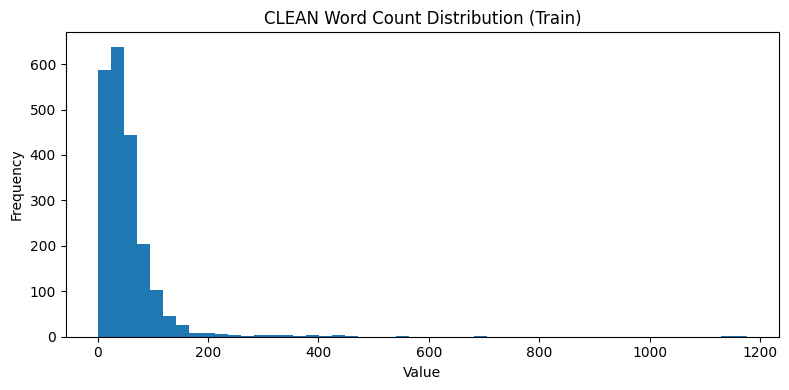

Grafikon mentve: /app/output/reports/02-preparation_clean_word_count_hist.png


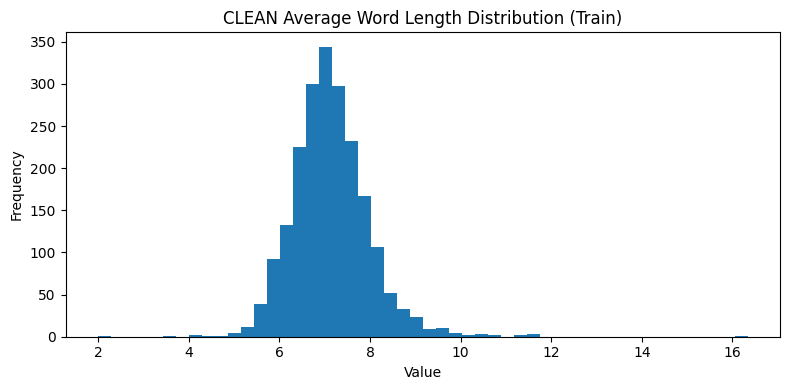

Grafikon mentve: /app/output/reports/02-preparation_clean_avg_word_len_hist.png


In [16]:
# Clean EDA histograms (from train split)
if len(train_df) > 0 and 'text' in train_df.columns:
    temp = add_text_stats(train_df)
    
    if 'word_count' in temp.columns:
        save_histogram(temp['word_count'], 'CLEAN Word Count Distribution (Train)',
                       os.path.join(features_dir, f'{STEP_PREFIX}_clean_word_count_hist.png'))
    
    if 'avg_word_len' in temp.columns:
        save_histogram(temp['avg_word_len'], 'CLEAN Average Word Length Distribution (Train)',
                       os.path.join(features_dir, f'{STEP_PREFIX}_clean_avg_word_len_hist.png'))

## Adatelőkészítés befejezve!

Az adatok tisztítva, train/val/test split-re osztva és elmentve.